# Ground state enegry

* Molecule : $BeH_2$
* Bond length : 1.33 Angstroms
* Circuit knitting - Entanglement forging technique to reduce number of qubits

In [1]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem

from circuit_knitting_toolbox.entanglement_forging import EntanglementForgingAnsatz
from qiskit.circuit.library import TwoLocal, RealAmplitudes

from qiskit_ibm_runtime import QiskitRuntimeService, Options

import numpy as np
from qiskit.algorithms.optimizers import COBYLA
from circuit_knitting_toolbox.entanglement_forging import (
    EntanglementForgingGroundStateSolver,
)

import matplotlib.pyplot as plt


from typing import Union, List
from qiskit import QuantumCircuit, execute, IBMQ, Aer, assemble
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options, Estimator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import *
import pandas as pd
from qiskit.quantum_info import SparsePauliOp
from qiskit.algorithms.minimum_eigensolvers import VQE


# BeH2 molecule

In [2]:
molecule = Molecule(
    geometry=[
        ("H", [0.0, 0.0, -1.33]),
        ("Be", [0.0, 0.0, 0.0]),
        ("H", [0.0, 0.0, 1.33]),
    ],
    charge=0,
    multiplicity=1,
)
driver = PySCFDriver.from_molecule(molecule=molecule, basis="sto3g")
problem = ElectronicStructureProblem(driver)

In [ ]:
# bitstrings states: [(1, 0, 1, 0, 1, 0,0), (0, 1,0,1,1,0,0)]
num_qubits = 7
ansatz = EntanglementForgingAnsatz(
    circuit_u=RealAmplitudes(num_qubits, entanglement="linear",reps=1,parameter_prefix="y",insert_barriers=True),
    bitstrings_u=[(1, 0, 1, 0, 1, 0,0), (0, 1,0,1,1,0,0)],
)

#ansatz.circuit_u.draw()

In [4]:
ansatz.circuit_u.decompose().draw()

┌──────────┐ ░                                ░  ┌──────────┐
q_0: ┤ Ry(y[0]) ├─░───■────────────────────────────░──┤ Ry(y[7]) ├
     ├──────────┤ ░ ┌─┴─┐                          ░  ├──────────┤
q_1: ┤ Ry(y[1]) ├─░─┤ X ├──■───────────────────────░──┤ Ry(y[8]) ├
     ├──────────┤ ░ └───┘┌─┴─┐                     ░  ├──────────┤
q_2: ┤ Ry(y[2]) ├─░──────┤ X ├──■──────────────────░──┤ Ry(y[9]) ├
     ├──────────┤ ░      └───┘┌─┴─┐                ░ ┌┴──────────┤
q_3: ┤ Ry(y[3]) ├─░───────────┤ X ├──■─────────────░─┤ Ry(y[10]) ├
     ├──────────┤ ░           └───┘┌─┴─┐           ░ ├───────────┤
q_4: ┤ Ry(y[4]) ├─░────────────────┤ X ├──■────────░─┤ Ry(y[11]) ├
     ├──────────┤ ░                └───┘┌─┴─┐      ░ ├───────────┤
q_5: ┤ Ry(y[5]) ├─░─────────────────────┤ X ├──■───░─┤ Ry(y[12]) ├
     ├──────────┤ ░                     └───┘┌─┴─┐ ░ ├───────────┤
q_6: ┤ Ry(y[6]) ├─░──────────────────────────┤ X ├─░─┤ Ry(y[13]) ├
     └──────────┘ ░                          └───┘ ░ └───────────┘

In [6]:
# We have created here class called CircuitExecutor. Which will take input 1. Backend 2. Service 3. Hamiltonian
#4. ansatz, optimizer, initial point from the user. 4. will be different for every molecule
# By default the res_level = 1 i.e. M3 if you want to have ZNE(PEC) just put res_level = 2(3)
# By default opt_level = 3, you can change it accordingly, 3 is highest level optimization
# see the example below!


class CircuitExecutor:
    def __init__(self, back, service, problem, ansatz, optimizer, initial_point, observable = None, error_mit = True, res_level = 2, opt_level = 3, noise_model = None, shots = 1024):
        """
        Initialize a CircuitExecutor object.
        Args:
            service (QiskitRuntimeService): The Qiskit runtime service to use.
            error_mit (bool, optional): A flag indicating whether to use error mitigation when running the circuit.
                                        Defaults to True.
            noise_model: User have to give their own noise_model, Default is None. 
            back: user have to give the backend name as a string
            res_level: Resilience level 1 means M3, If user want to use ZNE or PEC he has to provide res_level=2 for ZNE and 3 for PEC                   opt_level: Optimization Level 3, user can change it from 0 to 3               
        """
        self.service = service
        self.backend = back
        self.error_mit = error_mit
        self.shots = shots
        self.noise_model = noise_model
        self.res_level = res_level
        self.opt_level = opt_level
        self.observable = observable
        self.problem = problem
        self.ansatz = ansatz
        self.optimizer=optimizer
        self.initial_point = initial_point
        self.result = []

    def execute(self, back):

        """
        Execute a quantum circuit.
        Args:
            circuits (QuantumCircuit or a list of circuits): The quantum circuit/s to execute.
        Returns:
            Result: The result of executing the circuit.
        """
        options_with_em = Options(
            simulator={
                "noise_model": self.noise_model,
                "seed_simulator": 42,
            }, resilience_level = self.res_level, optimization_level = self.opt_level )
        options= [Options(execution={"shots": 1000}, optimization_level = self.opt_level, resilience_level = self.res_level), 
                  Options(execution={"shots": 2000}, optimization_level = self.opt_level, resilience_level = self.res_level)]

        if self.error_mit:
            f = open("mit_res.txt","w")
            with Session(service = self.service, backend=backend, max_time='3h') as session:
                if back[0] =="ibmq_qasm_simulator":
                    if self.noise_model == None:
                        raise ValueError("Please Give suitable noise model. You have not selected any noise model with qasm simulator")
                    else:
                        opt = options_with_em
                else:
                    opt = options
                
                solver = EntanglementForgingGroundStateSolver(
                    ansatz=self.ansatz,
                    optimizer=self.optimizer,
                    service=self.service,
                    backend_names=self.backend,
                    options=options,
                    initial_point=self.initial_point,
                )
                result = solver.solve(self.problem)
                return result

In [7]:
optimizer = COBYLA(maxiter=200)
np.random.seed(6)
initial_point = np.random.random(ansatz.circuit_u.num_parameters)
service = None
backend_names = ["ibmq_qasm_simulator"] * 2 

# Import FakeBackend
fake_backend = FakeManila()
noise_model = NoiseModel.from_backend(fake_backend)

executor = CircuitExecutor(backend_names, service, problem, ansatz, optimizer, res_level = 3, opt_level = 3, initial_point=initial_point, error_mit = True, noise_model = noise_model)


In [8]:
result= executor.execute(backend_names)
print(result) 

{   'aux_operator_eigenvalues': None,
    'eigenenergies': array([-12.97955143, -12.75203178, -12.84039547, -13.66106431,
       -13.67153809, -13.68622699, -13.7071306 , -13.31532852,
       -11.00824908, -13.7859039 , -13.85847106, -13.82453277,
       -13.8025908 , -13.83984382, -13.76623359, -15.05437403,
       -13.58337496, -15.77954323, -13.92304145, -15.53205713,
       -13.4727559 , -15.79173505, -13.71718063, -15.95164405,
       -14.62103433, -15.95101701, -16.12880586, -16.18645797,
       -16.20790439, -16.16571232, -15.21416058, -15.94641907,
       -16.34596382, -16.56975128, -14.66658859, -16.68457588,
       -15.42290513, -16.64804791, -16.21760878, -16.64881892,
       -16.67623775, -16.42863243, -16.74690334, -16.68093827,
       -16.70161124, -16.40613731, -16.77228544, -16.58799629,
       -16.8724084 , -16.8655643 , -16.87112913, -16.76927912,
       -16.84570821, -16.88862484, -16.88330467, -16.88560621,
       -16.78699202, -16.89629301, -16.87099681, -16.897048

In [9]:
result.groundenergy

-18.916602870167573

In [10]:
result.groundenergy +result.energy_shift

-15.534643251505917

Energy:


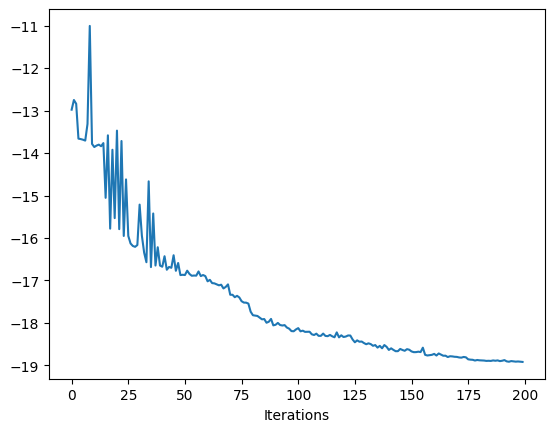

Schmidt Coefficients:


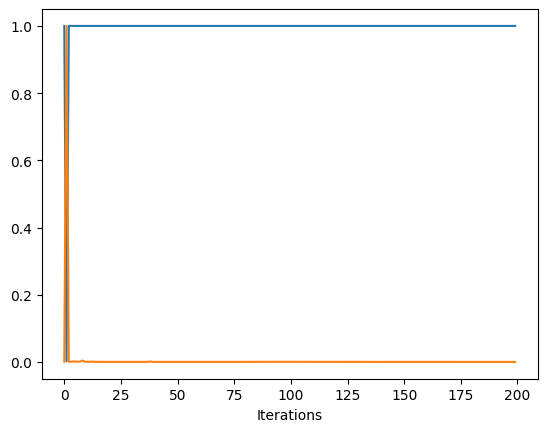

Parameters:


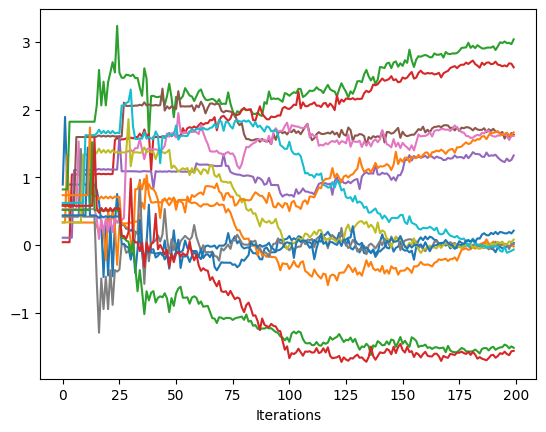

In [29]:
import matplotlib.pyplot as plt

print("Energy:")
plt.plot([evaluation.eigenvalue for evaluation in result.history])
plt.xlabel("Iterations")
plt.show()

print("Schmidt Coefficients:")
plt.plot([abs(evaluation.eigenstate) for evaluation in result.history])
plt.xlabel("Iterations")
#plt.yscale("log")
plt.show()

print("Parameters:")
plt.plot([evaluation.parameters for evaluation in result.history])
plt.xlabel("Iterations")
plt.show()

In [31]:
# runtime in seconds
result.elapsed_time

793.3759069442749

In [35]:
ansatz1.circuit_u.decompose().depth()

8